# Introduction

Dental caries, commonly known as cavities, remain one of the most prevalent oral health conditions worldwide. Early detection is critical for effective treatment and preventing further tooth damage. This project explores using deep learning to automate caries detection from dental X-ray images.

We'll build a convolutional neural network (CNN) that classifies dental images as either containing caries or being healthy. The approach includes data augmentation to expand our training set and regularization techniques (L2 + Dropout) to improve model generalization on unseen data.

In [1]:
# Import necessary libraries
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from PIL import Image
from sklearn.metrics import roc_curve, auc
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.regularizers import l2
import warnings
from sklearn.exceptions import UndefinedMetricWarning

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

In [2]:
# Set paths
train_dir = '/kaggle/input/tooth-decay-datasetraw/teeth_dataset/Trianing'
test_dir = '/kaggle/input/tooth-decay-datasetraw/teeth_dataset/test'

# Exploratory Data Analysis (EDA)

In [3]:
# Count the number of images in each class
train_caries_count = len(os.listdir(os.path.join(train_dir, 'caries')))
train_no_caries_count = len(os.listdir(os.path.join(train_dir, 'without_caries')))
test_caries_count = len(os.listdir(os.path.join(test_dir, 'caries')))
test_no_caries_count = len(os.listdir(os.path.join(test_dir, 'no-caries')))

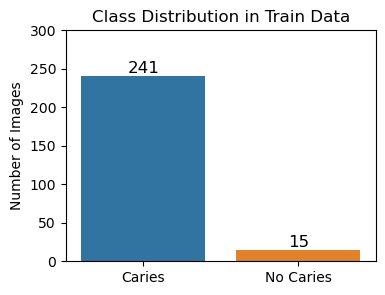

In [4]:
# Create a bar plot to visualize class distribution
plt.figure(figsize=(4, 3))
sns.barplot(x=['Caries', 'No Caries'], y=[train_caries_count, train_no_caries_count])
plt.title('Class Distribution in Train Data')
plt.ylabel('Number of Images')
plt.ylim(0, 300) 

# Add data labels to the bars
for i, count in enumerate([train_caries_count, train_no_caries_count]):
    plt.text(i, count, str(count), ha='center', va='bottom', fontsize=12)

plt.show()

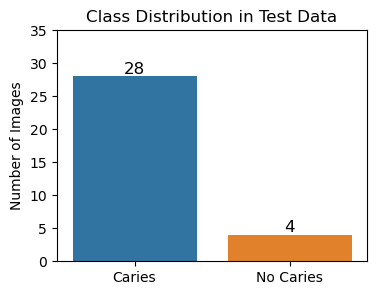

In [5]:
# Create a bar plot to visualize class distribution
plt.figure(figsize=(4, 3))
sns.barplot(x=['Caries', 'No Caries'], y=[test_caries_count, test_no_caries_count])
plt.title('Class Distribution in Test Data')
plt.ylabel('Number of Images')
plt.ylim(0, 35) 

# Add data labels to the bars
for i, count in enumerate([test_caries_count, test_no_caries_count]):
    plt.text(i, count, str(count), ha='center', va='bottom', fontsize=12)

plt.show()

### Histograms of Pixel Intensities

(array([  4849.,   2770.,   3628.,   4246.,   5525.,   9029.,   9038.,
          9472.,   9138.,   9443.,  12718.,  11455.,  14239.,  16331.,
         16934.,  19239.,  22448.,  24727.,  24893.,  25320.,  31545.,
         29307.,  32396.,  33061.,  36557.,  40231.,  45166.,  49547.,
         49957.,  53184.,  75926.,  74591.,  75449.,  76297.,  71604.,
         72190.,  76231.,  89303., 102724.,  93298., 111549.,  99654.,
        101396.,  97743.,  89490.,  64500.,  58733.,  65733.,  58590.,
         46526.]),
 array([  0.        ,   5.0999999 ,  10.19999981,  15.30000019,
         20.39999962,  25.5       ,  30.60000038,  35.70000076,
         40.79999924,  45.90000153,  51.        ,  56.09999847,
         61.20000076,  66.30000305,  71.40000153,  76.5       ,
         81.59999847,  86.69999695,  91.80000305,  96.90000153,
        102.        , 107.09999847, 112.19999695, 117.30000305,
        122.40000153, 127.5       , 132.6000061 , 137.69999695,
        142.80000305, 147.8999939 , 

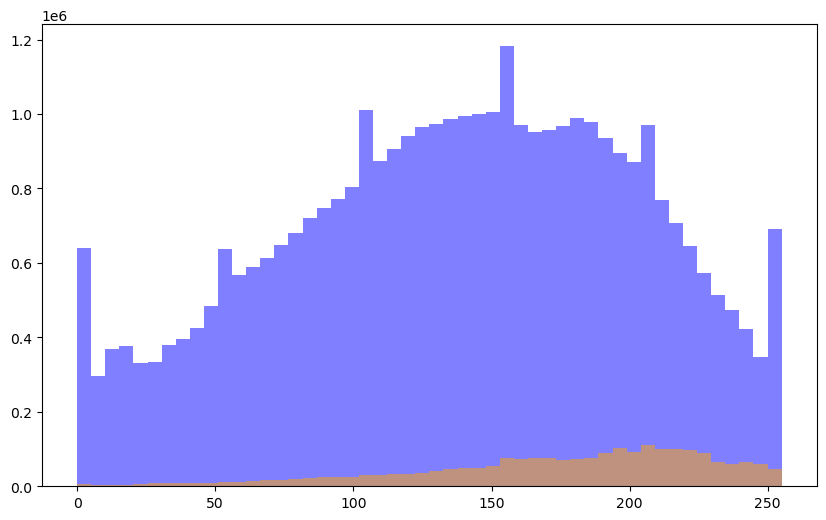

In [6]:
# Define the target image size
target_size = (224, 224)

# Load caries images as a NumPy array
caries_image_paths = [os.path.join(train_dir, 'caries', filename) for filename in os.listdir(os.path.join(train_dir, 'caries'))]
caries_images = []
for img_path in caries_image_paths:
    img = load_img(img_path, target_size=target_size)
    img_array = img_to_array(img)
    caries_images.append(img_array)
caries_images = np.array(caries_images)

# Load no caries images as a NumPy array
no_caries_image_paths = [os.path.join(train_dir, 'without_caries', filename) for filename in os.listdir(os.path.join(train_dir, 'without_caries'))]
no_caries_images = []
for img_path in no_caries_image_paths:
    img = load_img(img_path, target_size=target_size)
    img_array = img_to_array(img)
    no_caries_images.append(img_array)
no_caries_images = np.array(no_caries_images)

# Plot histograms of pixel intensities
plt.figure(figsize=(10, 6))
plt.hist(caries_images.flatten(), bins=50, color='blue', alpha=0.5, label='Caries')
plt.hist(no_caries_images.flatten(), bins=50, color='orange', alpha=0.5, label='No Caries')

## Displaying Sample Images from Each Class

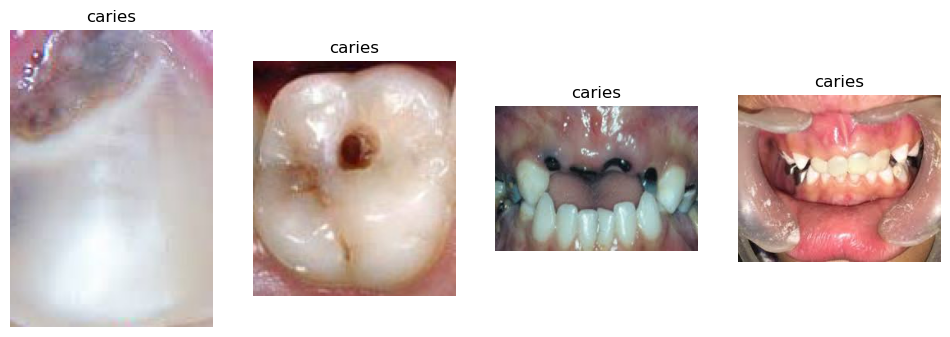

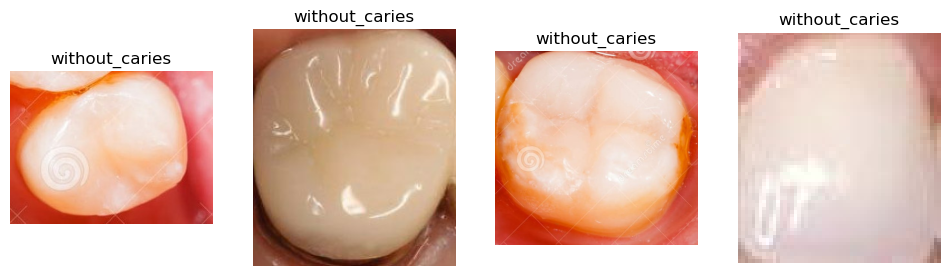

In [7]:
def display_samples(class_name, directory):
    plt.figure(figsize=(12, 6))
    for i in range(4):
        image_path = os.path.join(directory, class_name, os.listdir(os.path.join(directory, class_name))[i])
        img = Image.open(image_path)
        plt.subplot(1, 4, i + 1)
        plt.imshow(img)
        plt.title(class_name)
        plt.axis('off')
    plt.show()

display_samples('caries', train_dir)
display_samples('without_caries', train_dir)